## Moving average process
In a moving average (MA) process, the current value depends linearly on the mean of
the series, the current error term, and past error terms.
The moving average model is denoted as MA(q), where q is the order. The general
expression of an MA(q) model is  
        $y_t = µ + ϵ_t + θ_1ϵ_{t–1} + θ_2ϵ_{t–2} +⋅⋅⋅+ θ_qϵ_{t–q}$

The order q of the moving average model determines the number of past error terms
that affect the present value. For example, if it is of order 1, meaning that we have an
MA(1) process, the model is expressed as in equation 4.2. Here we can see that the
present value yt is dependent on the mean µ, the present error term ϵt, and the error
term at the previous timestep θ1ϵt –1.  
yt = µ + ϵt + θ1ϵt –1

If we have a moving average process of order 2, or MA(2), then yt is dependent on the
mean of the series µ, the present error term ϵt, the error term at the previous timestep
θ1ϵt –1, and the error term two timesteps prior θ2ϵt –2, resulting in equation 4.3.  
yt = µ + ϵt + θ1ϵt –1 + θ2ϵt –2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline

## Identifying the order of a moving average process

In [2]:
df = pd.read_csv("../data/widget_sales.csv")
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


In [5]:
def plot_data(df):
    fig, ax = plt.subplots()

    ax.plot(df['widget_sales'])
    ax.set_xlabel('Time')
    ax.set_ylabel('Widget sales (k$)')

    plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
    
    fig.autofmt_xdate()
    plt.tight_layout()

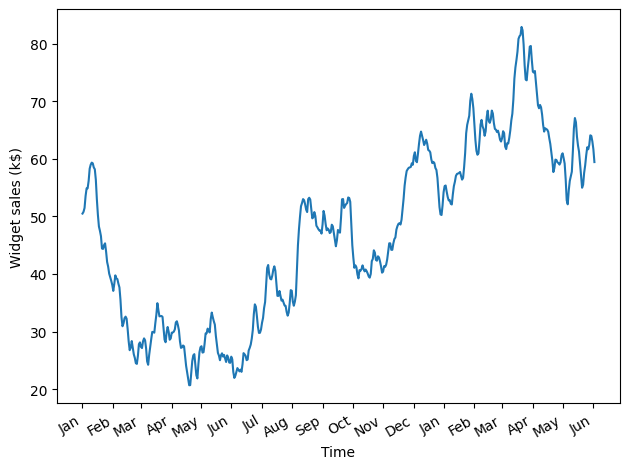

In [8]:
plot_data(df)

## Test for stationarity

we will use the ADF test
to make sure. Again, we’ll use the adfuller function from the statsmodels library
and extract the ADF statistic and p-value. If the ADF statistic is a large negative number and the p-value is smaller than 0.05, our series is stationary. Otherwise, we must
apply transformations.

In [9]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df['widget_sales'])

print(f"ADF Statistics: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")  ## Not stationary

ADF Statistics: -1.5121662069359032
p-value: 0.5274845352272612


## Make stationary

In [10]:
import numpy as np

# Apply first-order differencing on our data
widget_sales_diff = np.diff(df['widget_sales'], n=1)

In [ ]:
widget_sales_diff

In [11]:
ADF_result = adfuller(widget_sales_diff)

print(f"ADF Statistics: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")  
##stationary large negative ADF statistic and a p-value much smaller than 0.05


ADF Statistics: -10.576657780341955
p-value: 7.076922818587346e-19


## Plot the autocorrelation function

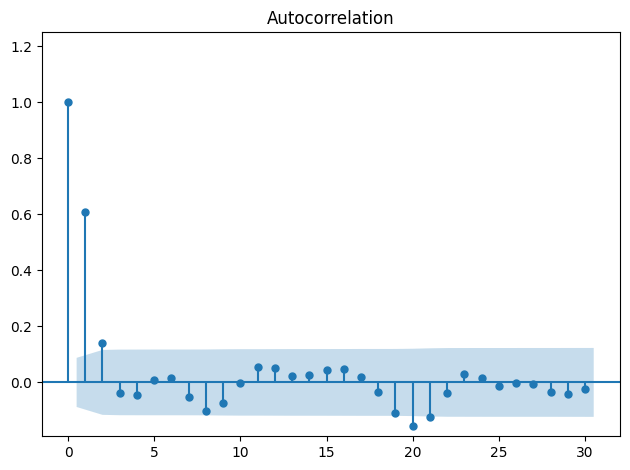

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(widget_sales_diff, lags=30, auto_ylims=True)
plt.tight_layout()

There are significant coefficients up unitl lag 2.then they abruptly become insignificant as they remain in the shaded portion. This means we have a stationary moving average process of order 2. We can use a second-order moving average model or MA(2) model

## Forecasting a moving average process

In [13]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})

train = df_diff[:int(0.9 * len(df_diff))]
test = df_diff[int(0.9 * len(df_diff)):]

print(len(train))
print(len(test))

#We lose a datapoint because we differenced once

449
50


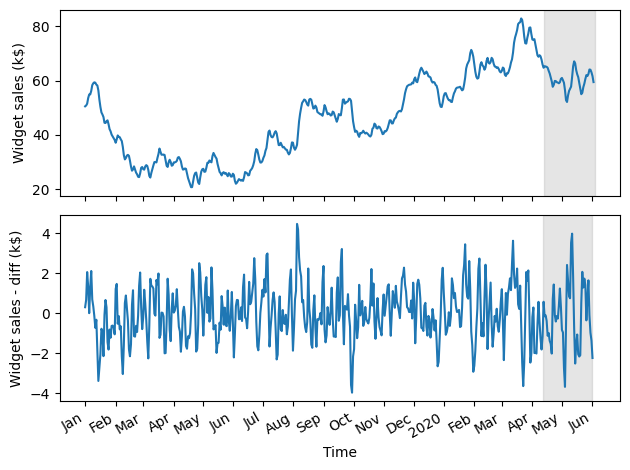

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True) #Make 2 subplots in the same figure
ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)
plt.xticks(
[0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()

## Forecasting using the MA(q) model
When using an MA(q) model, forecasting beyond q steps into the future will simply
return the mean, because there are no error terms to estimate beyond q steps. We
can use rolling forecasts to predict up to q steps at a time in order avoid predicting
only the mean of the series.

SARIMAX is a
complex model that allows us to consider seasonal effects, autoregressive processes,
non-stationary time series, moving average processes, and exogenous variables all in a
single model

Next, we define our rolling_forecast function. It will take in a DataFrame, the
length of the training set, the forecast horizon, a window size, and a method.
The DataFrame contains the entire time series.
The train_len parameter initializes the number of data points that can be
used to fit a model. As predictions are done, we can update this to simulate the
observation of new values and then use them to make the next sequence of
forecasts.
The horizon parameter is equal to the length of the test set and represents how
many values must be predicted.
The window parameter specifies how many timesteps are predicted at a time. In
our case, because we have an MA(2) process, the window will be equal to 2.
The method parameter specifies what model to use. The same function allows us
to generate forecasts from the naive methods and the MA(2) model.

In [17]:
list(range(0, 10, 2))

[0, 2, 4, 6, 8]

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == "mean":
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean
    
    elif method == "last":
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == "MA":
        pred_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window -1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)

        return pred_MA


In [19]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')
pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA
pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


Keep
in mind that we are still working with the differenced dataset, so our predictions are
also differenced values.

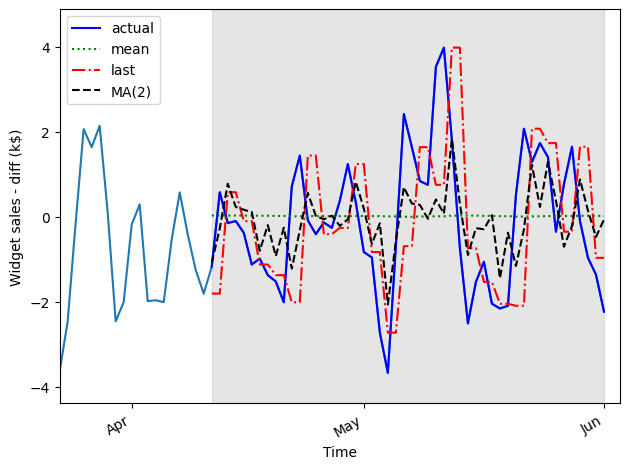

In [20]:
fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(449, 498, color='#808080', alpha=0.2)

ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498], 
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [21]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'],  pred_df['pred_MA'])
print(mse_mean, mse_last, mse_MA)

2.5606299456880537 3.2494260812249225 1.9481714497658182


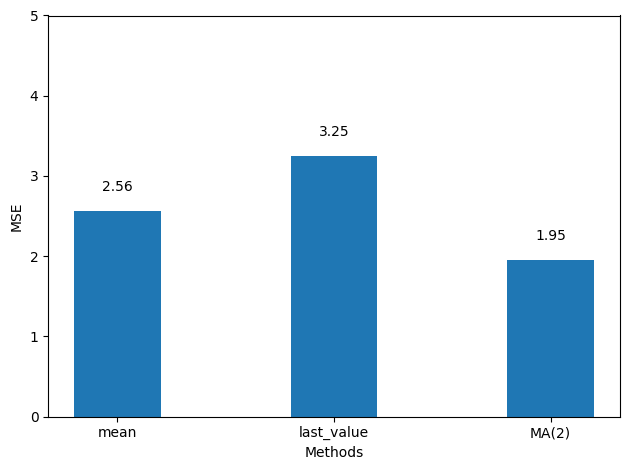

In [22]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In order to reverse our first-order difference, we need to add an initial value y0 to
the first differenced value y'1

$y1 = y0 + y'1 = y0 + y1 – y0 = y1$

$y2 = y0 + y'1 + y'2 = y0 + y1 – y0 + y2 – y1 = (y0 – y0) + (y1 – y1) + y2 = y2$

In [25]:
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

/tmp/ipykernel_64908/888517700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()


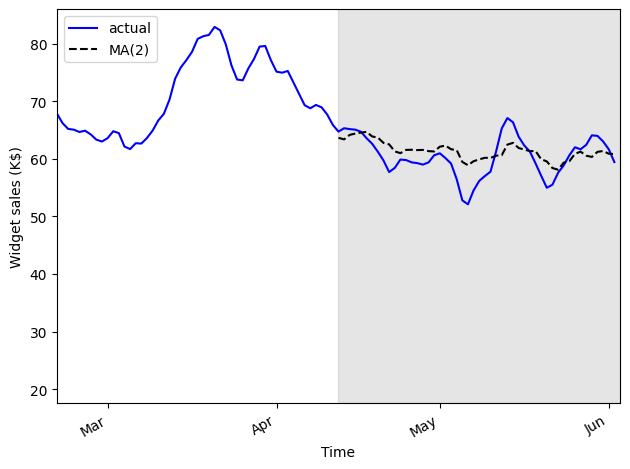

In [26]:
fig, ax = plt.subplots()
ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')
ax.axvspan(450, 500, color='#808080', alpha=0.2)

ax.set_xlim(400, 500)
plt.xticks(
[409, 439, 468, 498],
['Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()

In [27]:
from sklearn.metrics import mean_absolute_error
mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:],  df['pred_widget_sales'].iloc[450:])
print(mae_MA_undiff)

2.3244709245172395


This prints out an MAE of 2.32. Therefore, our predictions are, on average, off by
$2,320, either above or below the actual value. Remember that our data has units of
thousands of dollars, so we multiply the MAE by 1,000 to express the average absolute
difference.